In [1]:
import pandas as pd
import numpy as np
import math 
import time
import requests
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from pandas.io.json import json_normalize 
from tqdm import tqdm_notebook as tqdm
from ast import literal_eval
from scipy.stats import entropy
from sklearn.model_selection import KFold,StratifiedKFold
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

In [2]:
def slidingWindow(sequence,winSize,step=1):

    numOfChunks = int((len(sequence)-winSize)/step)+1
    for i in range(0,numOfChunks*step,step):
        
        if len(list(sequence[i+winSize:i+winSize+step]))!=0:
            yield list(sequence[i:i+winSize]),list(sequence[i+winSize:i+winSize+step])

In [3]:
def rename(concatenated):
    """
    :type concatenated: dateframe
    """
    
    concatenated.rename(columns={
        'FTHG': 'home_team_goal_count', 'FTAG': 'away_team_goal_count',
        'HY':'home_team_yellow_cards','AY':'away_team_yellow_cards',
        'HR':'home_team_red_cards','AR':'away_team_red_cards',
        'HST':'home_team_shots_on_target','AST':'away_team_shots_on_target',
        'HomeTeam':'home_team_name','AwayTeam':'away_team_name',
        'HC':'home_team_corner_count','AC':'away_team_corner_count',
        'HS':'home_team_shots','AS':'away_team_shots',
        'PSH':'odds_ft_home_team_win','PSA':'odds_ft_away_team_win',
        },inplace=True)

In [4]:
def plot_res(x,title):
    '''Plot profit by every year'''
    plt.title(title)

    plt.plot(x.loc[x.season==19].profit.cumsum())
    plt.plot(x.loc[x.season==18].profit.cumsum())
    plt.plot(x.loc[x.season==17].profit.cumsum())
    plt.plot(x.loc[x.season==16].profit.cumsum())
    
    plt.show() 

In [5]:
def get_all_results(x, h_goals, a_goals, h_win, h_loose, h_draw,
                    a_win, a_loose, a_draw, h_clean , a_clean,h_shutout,a_shutout):
    
    if x[h_goals] > x[a_goals]:
        x[h_win] = 1
        x[h_loose] = 0
        x[h_draw] = 0
        x['home_points'] = 3
        x[a_win] = 0
        x[a_loose] = 1
        x[a_draw] = 0
        x['away_points'] = 0
        x['Match_result']='H'
    elif x[h_goals] < x[a_goals]:
        x[h_win] = 0
        x[h_loose] = 1
        x[h_draw] = 0
        x['home_points'] = 0
        x[a_win] = 1
        x[a_loose] = 0
        x[a_draw] = 0
        x['away_points'] = 3
        x['Match_result']='A'
    else:
        x[h_win] = 0
        x[h_loose] = 0
        x[h_draw] = 1
        x['home_points'] = 1
        x[a_win] = 0
        x[a_loose] = 0
        x[a_draw] = 1
        x['away_points'] = 1
        x['Match_result']='D'
        
    if x[a_goals]==0:
        x[h_clean]=1
    else:
        x[h_clean]=0
        
    if x[h_goals]==0:
        x[a_clean]=1
    else:
        x[a_clean]=0
        
    if (x[a_goals]==0)&(x[h_goals]==0):
        x[h_shutout]=1
        x[a_shutout]=1
    else:   
        x[h_shutout]=0
        x[a_shutout]=0
        
    return x  

In [6]:
def get_result(x, h_goals, a_goals, result):
    """
    Result of game
    """
    if (x[h_goals]-x[a_goals])>0 :
        x[result]=1
    elif (x[h_goals]-x[a_goals])<0 :
        x[result]=2
    else:
        x[result]=0
        
    return x  

In [7]:
#get profit with no coefficient
def get_profit_simple(x):
    
    if (x['prediction']==1) :
        if (x['result']==1):
            x['profit']=x['odds_ft_home_team_win']-1
        else:
            x['profit']=-1
    elif x['prediction']==2  :
        if x['result']==2:
            x['profit']=x['odds_ft_away_team_win']-1
        else:
            x['profit']=-1
            
    return x  

In [8]:
#get profit with coefficient k
def get_profit_k(x,k):
    
    if (x['prediction']==1):
        if (x['result']==1):
            x['profit'] = k-k/x['odds_ft_home_team_win']
        else:
            x['profit'] = -k/x['odds_ft_home_team_win']
    elif x['prediction'] == 2 :
        if x['result'] == 2:
            x['profit'] = k-k/x['odds_ft_away_team_win']
        else:
            x['profit'] = -k/x['odds_ft_away_team_win']
            
    return x  

In [9]:
def get_league_abr_name(df): 
    name =[x for x in globals() if globals()[x] is df and x!= 'i'][0]
    return name[0:2]

def get_league_full_name(df): 
    name =[x for x in globals() if globals()[x] is df and x!= 'i'][0]
    return name

def get_season(df): 
    name =[x for x in globals() if globals()[x] is df and x!= 'i'][0]
    return name[-2:]

def get_team_names(df):
    return set(df['H_team'])

In [10]:
#create features
def prepare_data_window(concat):
        
        #add match results
        concat = concat.apply(lambda x: get_all_results(x, 'home_team_goal_count', 'away_team_goal_count',
                                           'total_h_win', 'total_h_loose', 'total_h_draw',
                                          'total_a_win', 'total_a_loose', 'total_a_draw',
                                          'home_clean_sheet','away_clean_sheet','home_shutout','away_shutout'),axis=1)
        #away team wins, lolses and draws
        concat_cumsum_away = pd.concat([concat.groupby(['away_team_name']).cumsum(), concat['away_team_name']],
                                       axis=1)
        away_score = concat_cumsum_away.groupby(['away_team_name'])[['total_a_win',
                                                                 'total_a_loose','total_a_draw']].shift(1).fillna(0)
        away_score.columns = ['a_wins','a_looses','a_draws']
        #home team wins, lolses and draws
        concat_cumsum_home = pd.concat([concat.groupby(['home_team_name']).cumsum(), concat['home_team_name']],
                                       axis=1)
        home_score = concat_cumsum_home.groupby(['home_team_name'])[['total_h_win',
                                                                 'total_h_loose','total_h_draw']].shift(1).fillna(0)
        home_score.columns = ['h_wins','h_looses','h_draws']
        
        concat['team_draw'] = concat.FTR.replace({'A': 0,'H': 0, 'D': 1})
        
        #sum by team and season
        def get_sum(team_name,column,name_column,season):
            
            concat_team = pd.concat([concatenated.groupby([team_name,season])
                                            [column].apply(lambda x: x.expanding().sum()),
                                            concatenated[[team_name,season]]], axis=1)
            team_mean = concat_team.groupby([team_name,season])[[column]].shift(1).fillna(0)
            team_mean.columns = [name_column]
            return team_mean
        
        home_sum_goals = get_sum('home_team_name','home_team_goal_count','home_team_goal_count_sum','season')
        away_sum_goals = get_sum('away_team_name','away_team_goal_count','away_team_goal_count_sum','season')

        home_sum_missed_goals = get_sum('home_team_name','away_team_goal_count','home_team_missed_goals_sum','season')
        away_sum_missed_goals = get_sum('away_team_name','home_team_goal_count','away_team_missed_goals_sum','season')

        #ewm5 by team and season
        def get_mean_5(team_name,column,name_column,season):
            
            concat_team = pd.concat([concat.groupby([team_name,season])
                                            [column].apply(lambda x: x.ewm(span=5).mean()),
                                            concat[[team_name,season]]], axis=1)
            team_mean = concat_team.groupby([team_name,season])[[column]].shift(1).fillna(0)
            team_mean.columns = [name_column]
            return team_mean
        
        
        home_mean_5_yellow_cards = get_mean_5('home_team_name','home_team_yellow_cards','home_mean_5_yellow_cards','season')
        away_mean_5_yellow_cards = get_mean_5('away_team_name','away_team_yellow_cards','away_mean_5_yellow_cards','season')
        
        home_mean_5_red_cards = get_mean_5('home_team_name','home_team_red_cards','home_mean_5_red_cards','season')
        away_mean_5_red_cards = get_mean_5('away_team_name','away_team_red_cards','away_mean_5_red_cards','season')
        
        home_mean_5_corner_count = get_mean_5('home_team_name','home_team_corner_count','home_mean_5_corner_count','season')
        away_mean_5_corner_count = get_mean_5('away_team_name','away_team_corner_count','away_mean_5_corner_count','season')

        home_mean_5_goals = get_mean_5('home_team_name','home_team_goal_count','home_team_goal_count_mean_5','season')
        away_mean_5_goals = get_mean_5('away_team_name','away_team_goal_count','away_team_goal_count_mean_5','season')

        home_mean_5_missed_goals = get_mean_5('home_team_name','away_team_goal_count','home_team_missed_goals_mean_5','season')
        away_mean_5_missed_goals = get_mean_5('away_team_name','home_team_goal_count','away_team_missed_goals_mean_5','season')

        home_mean_5_shots_on_target = get_mean_5('home_team_name','home_team_shots_on_target','home_mean_5_shots_on_target','season')
        away_mean_5_shots_on_target = get_mean_5('away_team_name','away_team_shots_on_target','away_mean_5_shots_on_target','season')
        
        home_mean_5_shots = get_mean_5('home_team_name','home_team_shots','home_mean_5_shots','season')
        away_mean_5_shots = get_mean_5('away_team_name','away_team_shots','away_mean_5_shots','season')
        
        home_mean_ppg_5 = get_mean_5('home_team_name','home_points','home_mean_ppg_5','season')
        away_mean_ppg_5 = get_mean_5('away_team_name','away_points','away_mean_ppg_5','season')
        
        home_clean_sheets_5 = get_mean_5('home_team_name','home_clean_sheet','home_clean_sheets_5','season')
        away_clean_sheets_5 = get_mean_5('away_team_name','away_clean_sheet','away_clean_sheets_5','season')
        
        home_shutout_mean_5 = get_mean_5('home_team_name','home_shutout','home_shutout_5','season')
        away_shutout_mean_5 = get_mean_5('away_team_name','away_shutout','away_shutout_5','season')
        
        home_draws_mean_5 = get_mean_5('home_team_name','team_draw','home_draw_percent','season')
        away_draws_mean_5 = get_mean_5('away_team_name','team_draw','away_draw_percent','season')
        
        home_elo_5 = get_mean_5('home_team_name','home_elo','home_elo_5','season')
        away_elo_5 = get_mean_5('away_team_name','away_elo','away_elo_5','season')
        
        home_def_elo_5 = get_mean_5('home_team_name','home_elo_def','home_def_elo_5','season')
        away_def_elo_5 = get_mean_5('away_team_name','away_elo_def','away_def_elo_5','season')
        
        home_attack_elo_5 = get_mean_5('home_team_name','home_elo_attack','home_attack_elo_5','season')
        away_attack_elo_5 = get_mean_5('away_team_name','away_elo_attack','away_attack_elo_5','season')
        
        #ewm10 by team and season
        def get_mean_10(team_name,column,name_column,season):
            
            concat_team = pd.concat([concat.groupby([team_name,season])
                                            [column].apply(lambda x: x.ewm(span=10).mean()),
                                            concat[[team_name,season]]], axis=1)
            team_mean = concat_team.groupby([team_name,season])[[column]].shift(1).fillna(0)
            team_mean.columns = [name_column]
            return team_mean
        
        
        home_mean_3_yellow_cards = get_mean_10('home_team_name','home_team_yellow_cards','home_mean_3_yellow_cards','season')
        away_mean_3_yellow_cards = get_mean_10('away_team_name','away_team_yellow_cards','away_mean_3_yellow_cards','season')
        
        home_mean_3_red_cards = get_mean_10('home_team_name','home_team_red_cards','home_mean_3_red_cards','season')
        away_mean_3_red_cards = get_mean_10('away_team_name','away_team_red_cards','away_mean_3_red_cards','season')
        
        home_mean_3_corner_count = get_mean_10('home_team_name','home_team_corner_count','home_mean_3_corner_count','season')
        away_mean_3_corner_count = get_mean_10('away_team_name','away_team_corner_count','away_mean_3_corner_count','season')

        home_mean_3_goals = get_mean_10('home_team_name','home_team_goal_count','home_team_goal_count_mean_3','season')
        away_mean_3_goals = get_mean_10('away_team_name','away_team_goal_count','away_team_goal_count_mean_3','season')

        home_mean_3_missed_goals = get_mean_10('home_team_name','away_team_goal_count','home_team_missed_goals_mean_3','season')
        away_mean_3_missed_goals = get_mean_10('away_team_name','home_team_goal_count','away_team_missed_goals_mean_3','season')

        home_mean_3_shots_on_target = get_mean_10('home_team_name','home_team_shots_on_target','home_mean_3_shots_on_target','season')
        away_mean_3_shots_on_target = get_mean_10('away_team_name','away_team_shots_on_target','away_mean_3_shots_on_target','season')
        
        home_mean_3_shots = get_mean_10('home_team_name','home_team_shots','home_mean_3_shots','season')
        away_mean_3_shots = get_mean_10('away_team_name','away_team_shots','away_mean_3_shots','season')
        
        home_mean_ppg_3 = get_mean_10('home_team_name','home_points','home_mean_ppg_3','season')
        away_mean_ppg_3 = get_mean_10('away_team_name','away_points','away_mean_ppg_3','season')
        
        home_clean_sheets_3 = get_mean_10('home_team_name','home_clean_sheet','home_clean_sheets_3','season')
        away_clean_sheets_3 = get_mean_10('away_team_name','away_clean_sheet','away_clean_sheets_3','season')
        
        home_shutout_mean_3 = get_mean_10('home_team_name','home_shutout','home_shutout_3','season')
        away_shutout_mean_3 = get_mean_10('away_team_name','away_shutout','away_shutout_3','season')
        
        home_elo_3 = get_mean_10('home_team_name','home_elo','home_elo_3','season')
        away_elo_3 = get_mean_10('away_team_name','away_elo','away_elo_3','season')
        
        home_def_elo_3 = get_mean_10('home_team_name','home_elo_def','home_def_elo_3','season')
        away_def_elo_3 = get_mean_10('away_team_name','away_elo_def','away_def_elo_3','season')
        
        home_attack_elo_3 = get_mean_10('home_team_name','home_elo_attack','home_attack_elo_3','season')
        away_attack_elo_3 = get_mean_10('away_team_name','away_elo_attack','away_attack_elo_3','season')
        
        def get_count_games(team_name, column, name_column, league2):
            
            concat_team = pd.concat([concat.groupby([team_name, league2])
                                            [column].apply(lambda x: x.expanding().count()),
                                            concat[team_name]], axis=1)
            team_count = concat_team[[column]]
            team_count.columns = [name_column]
            return team_count
        
        league_games_home = get_count_games('home_team_name','home_points','league_games_home','league2')
        league_games_away = get_count_games('away_team_name','home_points','league_games_away','league2')
        
        #prev team result
        def get_prev(team_name,column,name_column,season):
            
            concat_team = pd.concat([concat.groupby([team_name,season])
                                            [column].apply(lambda x: x.rolling(window=1).mean()),
                                            concat[[team_name,season]]], axis=1)
            team_mean = concat_team.groupby([team_name,season])[[column]].shift(1).fillna(0)
            team_mean.columns = [name_column]
            return team_mean
        
        home_prev_res_1 = get_prev('home_team_name','home_points','home_prev_res','season')
        away_prev_res_1 = get_prev('away_team_name','home_points','away_prev_res','season')
        
        concat = pd.concat([concat, away_score,home_score,
                            home_mean_5_goals,away_mean_5_goals,
                            home_mean_5_yellow_cards,away_mean_5_yellow_cards,
                            home_mean_5_corner_count,away_mean_5_corner_count,
                            home_mean_5_missed_goals,away_mean_5_missed_goals,
                            home_mean_5_shots_on_target,away_mean_5_shots_on_target,
                            home_mean_5_shots,away_mean_5_shots,
                            home_mean_5_red_cards,away_mean_5_red_cards,
                            home_mean_ppg_5,away_mean_ppg_5,
                            home_clean_sheets_5,away_clean_sheets_5,
                            home_elo_5,away_elo_5,
                            home_def_elo_5,away_def_elo_5,
                            home_attack_elo_5,away_attack_elo_5,
                            home_shutout_mean_5,away_shutout_mean_5,
                            home_draws_mean_5,away_draws_mean_5,
                            home_elo_3,away_elo_3,
                            home_def_elo_3,away_def_elo_3,
                            home_attack_elo_3,away_attack_elo_3,
                            home_mean_3_goals,away_mean_3_goals,
                            home_mean_3_yellow_cards,away_mean_3_yellow_cards,
                            home_mean_3_corner_count,away_mean_3_corner_count,
                            home_mean_3_missed_goals,away_mean_3_missed_goals,
                            home_mean_3_shots_on_target,away_mean_3_shots_on_target,
                            home_mean_3_shots,away_mean_3_shots,
                            home_mean_3_red_cards,away_mean_3_red_cards,
                            home_mean_ppg_3,away_mean_ppg_3,
                            home_clean_sheets_3,away_clean_sheets_3,
                            home_shutout_mean_3,away_shutout_mean_3,
                            league_games_home,league_games_away,
                            home_prev_res_1,away_prev_res_1,
                            home_sum_goals,away_sum_goals,
                            home_sum_missed_goals,away_sum_missed_goals],axis=1)

        concat['diff_mean_3_yellow_cards'] = concat['home_mean_3_yellow_cards']-concat['away_mean_3_yellow_cards']
        concat['diff_mean_3_corner_count'] = concat['home_mean_3_corner_count']-concat['away_mean_3_corner_count']
        concat['diff_team_goal_count_mean_3'] = concat['home_team_goal_count_mean_3']-concat['away_team_goal_count_mean_3']
        concat['diff_team_missed_goals_mean_3'] = concat['home_team_missed_goals_mean_3']-concat['away_team_missed_goals_mean_3']
        concat['diff_mean_3_shots_on_target'] = concat['home_mean_3_shots_on_target']-concat['away_mean_3_shots_on_target']
        concat['diff_mean_3_shots'] = concat['home_mean_3_shots']-concat['away_mean_3_shots']
        concat['diff_mean_ppg_3'] = concat['home_mean_ppg_3']-concat['away_mean_ppg_3']
        concat['diff_clean_sheets_3'] = concat['home_clean_sheets_3']-concat['away_clean_sheets_3']
        concat['mean_shutout_3'] = (concat['home_shutout_3']-concat['away_shutout_3'])
        concat['diff_elo_3'] = concat['home_elo_3']-concat['away_elo_3']
        concat['diff_def_elo_3'] = concat['home_def_elo_3']-concat['away_def_elo_3']
        concat['diff_attack_elo_3'] = concat['home_attack_elo_3']-concat['away_attack_elo_3']
        
        concat['diff_mean_5_yellow_cards'] = concat['home_mean_5_yellow_cards']-concat['away_mean_5_yellow_cards']
        concat['diff_mean_5_corner_count'] = concat['home_mean_5_corner_count']-concat['away_mean_5_corner_count']
        concat['diff_team_goal_count_mean_5'] = concat['home_team_goal_count_mean_5']-concat['away_team_goal_count_mean_5']
        concat['diff_team_missed_goals_mean_5'] = concat['home_team_missed_goals_mean_5']-concat['away_team_missed_goals_mean_5']
        concat['diff_mean_5_shots_on_target'] = concat['home_mean_5_shots_on_target']-concat['away_mean_5_shots_on_target']
        concat['diff_mean_5_shots'] = concat['home_mean_5_shots']-concat['away_mean_5_shots']
        concat['diff_mean_ppg_5'] = concat['home_mean_ppg_5']-concat['away_mean_ppg_5']
        concat['diff_clean_sheets_5'] = concat['home_clean_sheets_5']-concat['away_clean_sheets_5']
        concat['mean_shutout_5'] = (concat['home_shutout_5']-concat['away_shutout_5'])
        concat['diff_elo_5'] = concat['home_elo_5']-concat['away_elo_5']
        concat['diff_def_elo_5'] = concat['home_def_elo_5']-concat['away_def_elo_5']
        concat['diff_attack_elo_5'] = concat['home_attack_elo_5']-concat['away_attack_elo_5']
        #difference between mean10 and mean5
        concat['diff_mm5_home_mean_yellow_cards'] = concat['home_mean_3_yellow_cards']-concat['home_mean_5_yellow_cards']
        concat['diff_mm5_home_mean_corner_count'] = concat['home_mean_3_corner_count']-concat['home_mean_5_corner_count']
        concat['diff_mm5_home_team_goal_count_mean'] = concat['home_team_goal_count_mean_3']-concat['home_team_goal_count_mean_5']
        concat['diff_mm5_home_team_missed_goals_mean'] = concat['home_team_missed_goals_mean_3']-concat['home_team_missed_goals_mean_5']
        concat['diff_mm5_home_mean_shots_on_target'] = concat['home_mean_3_shots_on_target']-concat['home_mean_5_shots_on_target']
        concat['diff_mm5_home_mean_shots'] = concat['home_mean_3_shots']-concat['home_mean_5_shots']
        concat['diff_mm5_home_mean_ppg'] = concat['home_mean_ppg_3']-concat['home_mean_ppg_5']
        concat['diff_mm5_home_clean_sheets'] = concat['home_clean_sheets_3']-concat['home_clean_sheets_5']
        concat['diff_mm5_home_elo'] = concat['home_elo_3']-concat['home_elo_5']
        concat['diff_mm5_home_def_elo'] = concat['home_def_elo_3']-concat['home_def_elo_5']
        concat['diff_mm5_home_attack_elo'] = concat['home_attack_elo_3']-concat['home_attack_elo_5']
        
        concat['diff_mm5_away_mean_yellow_cards'] = concat['away_mean_3_yellow_cards']-concat['away_mean_5_yellow_cards']
        concat['diff_mm5_away_mean_corner_count'] = concat['away_mean_3_corner_count']-concat['away_mean_5_corner_count']
        concat['diff_mm5_away_team_goal_count_mean'] = concat['away_team_goal_count_mean_3']-concat['away_team_goal_count_mean_5']
        concat['diff_mm5_away_team_missed_goals_mean'] = concat['away_team_missed_goals_mean_3']-concat['away_team_missed_goals_mean_5']
        concat['diff_mm5_away_mean_shots_on_target'] = concat['away_mean_3_shots_on_target']-concat['away_mean_5_shots_on_target']
        concat['diff_mm5_away_mean_shots'] = concat['away_mean_3_shots']-concat['away_mean_5_shots']
        concat['diff_mm5_away_mean_ppg'] = concat['away_mean_ppg_3']-concat['away_mean_ppg_5']
        concat['diff_mm5_away_clean_sheets'] = concat['away_clean_sheets_3']-concat['away_clean_sheets_5']
        concat['diff_mm5_away_elo'] = concat['away_elo_3']-concat['away_elo_5']
        concat['diff_mm5_away_def_elo'] = concat['away_def_elo_3']-concat['away_def_elo_5']
       
        concat = concat.apply(lambda x: get_result(x, 'home_team_goal_count', 'away_team_goal_count','result'), axis=1)
                                                                     
        return concat

In [11]:
#final prediction using odds and model predicts with coefficient (convert all predictions to coefficient k)
def get_prediction(x, pred0, pred1, pred2, profit, odds_d, odds_h, odds_a, k,
                   difference_prob_min,difference_prob_max):
    
    h_diff = x[pred1]-1/x[odds_h]
    a_diff = x[pred2]-1/x[odds_a]
    d_diff = x[pred0]-1/x[odds_d]
    
    if (d_diff<2.5)&(x[pred1]!=0)&(x[pred2]!=0) :
            if (h_diff>difference_prob_min)&(h_diff<difference_prob_max)&(h_diff>a_diff) :
                x['prediction']=1
                if (x['result']==1):
                    x[profit]=k-k/x[odds_h]
                    x['diff_preds']=h_diff
                else:
                    x['diff_preds']=h_diff
                    x[profit]=-k/x[odds_h]
            elif (a_diff>difference_prob_min)&(a_diff<difference_prob_max)&(h_diff<a_diff) :
                x['prediction']=2
                if x['result']==2:
                    x[profit]=k-k/x[odds_a]
                    x['diff_preds']=a_diff
                else:
                    x[profit]=-k/x[odds_a]
                    x['diff_preds']=a_diff
            else:
                x['prediction']=3
                x[profit]=0
                x['diff_preds']=0
    else:
        x['prediction']=3
        x[profit]=0
        x['diff_preds']=0
        
    return x  

In [12]:
#final prediction using odds and model predicts
def get_prediction_simple(x, pred0, pred1, pred2, profit, odds_d, odds_h, odds_a, k,
                          difference_prob_min,difference_prob_max):
    
    h_diff = x[pred1]-1/x[odds_h]
    a_diff = x[pred2]-1/x[odds_a]
    d_diff = x[pred0]-1/x[odds_d]
    
    if (d_diff<2.5)&(x[pred1]!=0)&(x[pred2]!=0) :
            if (h_diff>difference_prob_min)&(h_diff<difference_prob_max)&(h_diff>a_diff) :
                x['prediction'] = 1
                if (x['result']==1):
                    x[profit]=x[odds_h]-1
                    x['diff_preds']=h_diff
                else:
                    x['diff_preds']=h_diff
                    x[profit]=-1
            elif (a_diff>difference_prob_min)&(a_diff<difference_prob_max)&(h_diff<a_diff) :
                x['prediction'] = 2
                if x['result']==2:
                    x[profit]=x[odds_a]-1
                    x['diff_preds']=a_diff
                else:
                    x[profit]=-1
                    x['diff_preds']=a_diff
            else:
                x['prediction'] = 3
                x[profit]=0
                x['diff_preds']=0
    else:
        x['prediction'] = 3
        x[profit]=0
        x['diff_preds']=0
        
    return x  

In [13]:
#final prediction using odds and model predicts (for overfitted model)
def get_prediction_overfit(x, pred0, pred1, pred2, profit, odds_d, odds_h, odds_a, k,
                            difference_prob_min,difference_prob_max):
    
    h_diff = x[pred1]-1/x[odds_h]
    a_diff = x[pred2]-1/x[odds_a]
    d_diff = x[pred0]-1/x[odds_d]
    
    if (d_diff<32.5)&(x[pred1]!=0)&(x[pred2]!=0) :
            if (h_diff>difference_prob_min)&(h_diff<difference_prob_max)&(x[pred1]>x[pred2]) :
                x['prediction'] = 1
                if (x['result']==1):
                    x[profit]=x[odds_h]-1
                    x['diff_preds']=h_diff
                else:
                    x['diff_preds']=h_diff
                    x[profit]=-1
            elif (a_diff>difference_prob_min)&(a_diff<difference_prob_max) :
                x['prediction'] = 2
                if x['result']==2:
                    x[profit]=x[odds_a]-1
                    x['diff_preds']=a_diff
                else:
                    x[profit]=-1
                    x['diff_preds']=a_diff
            else:
                x['prediction'] = 3
                x[profit]=0
                x['diff_preds']=0
    else:
        x['prediction'] = 3
        x[profit]=0
        x['diff_preds']=0
        
    return x  

In [14]:
#standart elo rating
def Probability(rating1, rating2): 
  
    return 1.0 * 1.0 / (1 + 1.0 * math.pow(10, 1.0 * (rating1 - rating2) / 400))

def EloRating2(Ra, Rb, result, K): 
   
    Pb = Probability(Ra, Rb) 
    Pa = Probability(Rb, Ra) 

    if (result == 'H') : 
        Ra = Ra + K * (1 - Pa) 
        Rb = Rb + K * (0 - Pb) 
      
    elif(result == 'A') : 
        Ra = Ra + K * (0 - Pa) 
        Rb = Rb + K * (1 - Pb) 

    else:
        Ra = Ra + K * (0.4 - Pa) 
        Rb = Rb + K * (0.6 - Pb) 
    
    return round(Ra, 1),round(Rb, 1)

In [15]:
#elo rating for ShotsOnTarget
def EloShotsOnTarget(Hse, Ase, Hde, Ade, sH, sA, K): 

    Pha = Probability(Hse, Ade) 
    Phh = Probability(Ade, Hse) 
    
    Paa = Probability(Hde, Ase) 
    Pah = Probability(Ase, Hde) 

    if sH < 5 :
        Hse = Hse + K * (0 - Phh) 
        Ade = Ade + K * (1 - Pha)
    else:
        Hse = Hse + K * (1 - Phh)
        Ade = Ade + K * (0 - Pha)
    if sA < 4 :
        Ase = Ase + K * (0 - Paa)
        Hde = Hde + K * (1 - Pah)
    else:
        Ase = Ase + K * (1 - Paa)
        Hde = Hde + K * (0 - Pah)
        
    return round(Hde, 1),round(Ade, 1),round(Hse, 1),round(Ase, 1)

In [16]:
#get mean stats given the home and away history mathces
def get_mean(name_new_column, column, window):
    
    unique_teams = list(concatenated.home_team_name.unique())
    unique_seasons = list(concatenated.season.unique())
    concatenated['home_'+name_new_column] = np.nan
    concatenated['away_'+name_new_column] = np.nan
    for team in unique_teams:
        for season in (unique_seasons):
            concatenated_season = concatenated.loc[concatenated.season==season]
            test1 = concatenated_season.loc[concatenated_season.home_team_name==team]
            test1.rename(columns={'home_'+column:column},inplace=True)
            test2 = concatenated_season.loc[concatenated_season.away_team_name==team]
            test2.rename(columns={'away_'+column:column},inplace=True)
            test3 = pd.concat([test1,test2]).sort_values(by=['Date'])
            test3[column] = test3[column].ewm(span=window).mean().shift(1)
            test3['home_'+name_new_column] = np.where(test3['home_team_name']== team, test3[column], np.nan)
            test3['away_'+name_new_column] = np.where(test3['away_team_name']== team, test3[column], np.nan)
            concatenated['home_'+name_new_column] = pd.concat([concatenated['home_'+name_new_column][~concatenated.index.isin(test3.loc[test3['home_'+name_new_column]>=0].index)], test3.loc[test3['home_'+name_new_column]>=0]['home_'+name_new_column]]).sort_index()
            concatenated['away_'+name_new_column] = pd.concat([concatenated['away_'+name_new_column][~concatenated.index.isin(test3.loc[test3['away_'+name_new_column]>=0].index)], test3.loc[test3['away_'+name_new_column]>=0]['away_'+name_new_column]]).sort_index()

In [17]:
def pred_res(df):
    df = df.fillna(0)
    df['prediction'] = df.filter(like='pred', axis=1).mode(axis=1)[0]
    df = df.loc[df.prediction!=0]
    df = df.apply(lambda x: get_profit_simple(x), axis=1)
    df = df.dropna(subset=['profit'])
    print(df.profit.sum())
    return df

## Read data

In [20]:
#read the data
#England 15-19
concatenated = pd.read_csv('../England_14_19.csv')
concatenated['Date'] =  pd.to_datetime(concatenated.Date,format="%Y-%m-%d")

In [21]:
concatenated['odds_ft_home_team_win'] = concatenated[['IWH','VCH','WHH','odds_ft_home_team_win','B365H']].max(axis=1)
concatenated['PSD'] = concatenated[['IWD','VCD','WHD','PSD','B365D']].max(axis=1)
concatenated['odds_ft_away_team_win'] = concatenated[['IWA','VCA','WHA','odds_ft_away_team_win','B365A']].max(axis=1)

In [22]:
#get standart elo
n1 = 1500
n2 = 1500
k = 30
concatenated['home_elo'],concatenated['away_elo'] = n2,n2
concatenated.loc[concatenated.season==14,'home_elo'] = n1
concatenated.loc[concatenated.season==14,'away_elo'] = n1
for index, row in tqdm(concatenated.iterrows()):
    elo=[]
    elo.append(EloRating2(concatenated.loc[concatenated.home_team_name==row.home_team_name].\
                groupby('home_team_name')[['home_elo']].shift(1).fillna(method='backfill').ix[index][0],
                         concatenated.loc[concatenated.away_team_name==row.away_team_name].\
                groupby('away_team_name')[['away_elo']].shift(1).fillna(method='backfill').ix[index][0],row.FTR,k))
    concatenated.at[index, 'home_elo'] = elo[0][0]
    concatenated.at[index, 'away_elo'] = elo[0][1]
concatenated['home_elo_shifted'] = concatenated.groupby(['home_team_name'])['home_elo'].shift(1).fillna(n2).values
concatenated['away_elo_shifted'] = concatenated.groupby(['away_team_name'])['away_elo'].shift(1).fillna(n2).values
concatenated['diff_elo_shifted'] = concatenated['home_elo_shifted']-concatenated['away_elo_shifted']

In [23]:
#get shots on target elo
n1 = 1500
n2 = 1500
k = 30
concatenated['home_elo_def'],concatenated['away_elo_def'] = n2,n2
concatenated.loc[concatenated.season==14,'home_elo_def'] = n1
concatenated.loc[concatenated.season==14,'away_elo_def'] = n1
concatenated['home_elo_attack'],concatenated['away_elo_attack'] = n2,n2
concatenated.loc[concatenated.season==14,'home_elo_attack'] = n1
concatenated.loc[concatenated.season==14,'away_elo_attack'] = n1
for index, row in tqdm(concatenated.iterrows()):
    elo_Def=[]
    elo_Def.append(EloShotsOnTarget(
        concatenated.loc[concatenated.home_team_name==row.home_team_name].groupby('home_team_name')[['home_elo_attack']].shift(1).fillna(method='backfill').ix[index][0],
        concatenated.loc[concatenated.away_team_name==row.away_team_name].groupby('away_team_name')[['away_elo_attack']].shift(1).fillna(method='backfill').ix[index][0],
        concatenated.loc[concatenated.home_team_name==row.home_team_name].groupby('home_team_name')[['home_elo_def']].shift(1).fillna(method='backfill').ix[index][0],
        concatenated.loc[concatenated.away_team_name==row.away_team_name].groupby('away_team_name')[['away_elo_def']].shift(1).fillna(method='backfill').ix[index][0],
        row.home_team_shots_on_target,row.away_team_shots_on_target,k))
    concatenated.at[index, 'home_elo_def'] = elo_Def[0][0]
    concatenated.at[index, 'away_elo_def'] = elo_Def[0][1]
    concatenated.at[index, 'home_elo_attack'] = elo_Def[0][2]
    concatenated.at[index, 'away_elo_attack'] = elo_Def[0][3]
concatenated['home_elo_def_shifted'] = concatenated.groupby(['home_team_name'])['home_elo_def'].shift(1).fillna(n2).values
concatenated['away_elo_def_shifted'] = concatenated.groupby(['away_team_name'])['away_elo_def'].shift(1).fillna(n2).values
concatenated['diff_shifted_def'] = concatenated['home_elo_def_shifted']-concatenated['away_elo_def_shifted']
concatenated['home_elo_attack_shifted'] = concatenated.groupby(['home_team_name'])['home_elo_attack'].shift(1).fillna(n2).values
concatenated['away_elo_attack_shifted'] = concatenated.groupby(['away_team_name'])['away_elo_attack'].shift(1).fillna(n2).values
concatenated['diff_shifted_attack'] = concatenated['home_elo_attack_shifted']-concatenated['away_elo_attack_shifted']

In [24]:
#time since the previous game usning Champions League and UEFA Europa League matches
full_euro = pd.read_csv('C:/Users/A/Documents/API_data/euro_leagues_14_18.csv')
full_euro['Date'] =  pd.to_datetime(full_euro.Date,format="%Y-%m-%d")
full_concat = pd.concat([concatenated,full_euro])
full_concat = full_concat.sort_values(by=['Date','home_team_name','away_team_name'])
full_concat = full_concat.reset_index(drop=True)

unique_teams = list(concatenated.home_team_name.unique())
for team in tqdm(unique_teams):
    full_concat2 = full_concat.loc[(full_concat.home_team_name==team)|(full_concat.away_team_name==team)]
    for index, row in full_concat2.iterrows():
        if full_concat2['home_team_name'][index] == team:
            full_concat2.at[index, 'place'] = 'h'
        else:
            full_concat2.at[index, 'place'] = 'a'
    full_concat2['diff_dates'] = (full_concat2.Date - full_concat2.Date.shift(1).fillna(full_concat['Date'])).\
                                                                                                        dt.days
    pd.to_numeric(full_concat2.diff_dates)
    for index, row in full_concat.iterrows():
        if full_concat['home_team_name'][index] == team:
            full_concat.at[index, 'home_diff_dates'] = full_concat2['diff_dates'][index]
        if full_concat['away_team_name'][index] == team:   
            full_concat.at[index, 'away_diff_dates'] = full_concat2['diff_dates'][index]

concatenated = full_concat.dropna(subset=['league2'])
concatenated['diff_prev_date2'] = concatenated['home_diff_dates'] - concatenated['away_diff_dates']

In [25]:
#get all stats by home and away matches separately
concatenated = prepare_data_window(concatenated)

In [26]:
#get all stats by home and away matches jointly
get_mean('mean_shots_on_target_5a','team_shots_on_target',5)
get_mean('mean_shots_on_target_10a','team_shots_on_target',10)

get_mean('mean_shots_5a','team_shots',5)
get_mean('mean_shots_10a','team_shots',10)

get_mean('mean_corner_count_5a','team_corner_count',5)
get_mean('mean_corner_count_10a','team_corner_count',10)

get_mean('mean_yellow_cards_5a','team_yellow_cards',5)
get_mean('mean_yellow_cards_10a','team_yellow_cards',10)

get_mean('mean_ppg_5a','points',5)
get_mean('mean_ppg_10a','points',10)

In [27]:
#new features
concatenated['diff_ppg_5'] = concatenated.home_mean_ppg_5a - concatenated.away_mean_ppg_5a
concatenated['diff_ppg_10'] = concatenated.home_mean_ppg_10a - concatenated.away_mean_ppg_10a

concatenated['diff_shots_on_target_5'] = concatenated.home_mean_shots_on_target_5a - concatenated.away_mean_shots_on_target_5a
concatenated['diff_shots_on_target_10'] = concatenated.home_mean_shots_on_target_10a - concatenated.away_mean_shots_on_target_10a

concatenated['diff_shots_5'] = concatenated.home_mean_shots_5a - concatenated.away_mean_shots_5a 
concatenated['diff_shots_10'] = concatenated.home_mean_shots_10a - concatenated.away_mean_shots_10a

concatenated['diff_yellow_cards_5'] = concatenated.home_mean_yellow_cards_5a - concatenated.away_mean_yellow_cards_5a
concatenated['diff_yellow_cards_10'] = concatenated.home_mean_yellow_cards_10a - concatenated.away_mean_yellow_cards_10a

concatenated['diff_corner_count_5'] = concatenated.home_mean_corner_count_5a - concatenated.away_mean_corner_count_5a
concatenated['diff_corner_count_10'] = concatenated.home_mean_corner_count_10a - concatenated.away_mean_corner_count_10a

concatenated['diff_away_mm5_yellow_cards'] = concatenated.away_mean_yellow_cards_10a-concatenated.away_mean_yellow_cards_5a
concatenated['diff_home_mm5_yellow_cards'] = concatenated.home_mean_yellow_cards_10a-concatenated.home_mean_yellow_cards_5a

concatenated['diff_away_mm5_corner_count'] = concatenated.away_mean_corner_count_10a-concatenated.away_mean_corner_count_5a
concatenated['diff_home_mm5_corner_count'] = concatenated.home_mean_corner_count_10a-concatenated.home_mean_corner_count_5a

In [28]:
#delete of the first matches of each season
concatenated = concatenated.dropna(subset=['odds_ft_home_team_win', 'odds_ft_away_team_win','PSD'])
concatenated = concatenated.loc[(concatenated.diff_elo_5!=0)&(concatenated.away_team_missed_goals_mean_5!=0)&\
                               (concatenated.home_elo_5!=0)]

for column in concatenated:
    if (concatenated[column].dtypes =='float64')|(concatenated[column].dtypes =='int64'):
        concatenated[column] = round(concatenated[column],3)

In [30]:
# from sklearn import preprocessing

# x = concatenated[top_cols_NB_norm].values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled)
# df2 = concatenated[['Date','odds_ft_home_team_win','odds_ft_away_team_win','PSD',
#                    'home_team_name', 'season', 'away_team_name', 'result','league']].reset_index(drop=True)
# df3 = pd.concat([df,df2],axis=1)

## Models

In [31]:
from sklearn.ensemble import RandomForestClassifier
clf1 = lgb.LGBMClassifier(min_child_samples = 15,learning_rate=0.2)
clf2 = GaussianNB()
clf3 = RandomForestClassifier(max_depth=2, random_state=0)

In [32]:
def model(pred_name_func, model_name, dataframe, k_profit, difference_prob_min, difference_prob_max, test_season,
                step,step2, swindow, ewindow, niterations):

    high_list = []
    concatenated_sub = concatenated.reset_index(drop=True)
    concatenated_sub_t = dataframe.reset_index(drop=True)

    full_res_naive = concatenated_sub[['home_team_name','away_team_name','odds_ft_home_team_win',
                                 'odds_ft_away_team_win','PSD','result','season','Date']].copy()

    for high_loop_step in range(1,niterations+1,1):
        print('iteration',high_loop_step)

        step += 1
        country_sum=[]
        full_profit=[]
        res = []

        concatenated_sub = concatenated_sub.dropna(subset=['odds_ft_home_team_win', 'odds_ft_away_team_win','PSD'])
        concatenated_sub_t = concatenated_sub_t.dropna(subset=['odds_ft_home_team_win', 'odds_ft_away_team_win','PSD'])

        test_data, main_targets = concatenated_sub.copy(), concatenated_sub['result']
        train_data, train_targets = concatenated_sub_t.copy(), concatenated_sub_t['result']

        vote_predictios = test_data[['home_team_name','away_team_name','odds_ft_home_team_win','odds_ft_away_team_win',
                            'Date','season','league','result']].copy()
        #roll top_cols
        new_top_cols = np.array(top_cols_NB)
        top_cols2 = list(np.roll(new_top_cols,step))

        test_data = test_data[top_cols2]
        train_data = train_data[top_cols2]
        #test_data = test_data.drop(['home_team_name', 'season', 'away_team_name', 'result','league'], axis=1)

        for j in np.arange(swindow,ewindow,1):
            #create date window
            window = j
            s = pd.Series(concatenated_sub.Date.dt.strftime('%Y-%m-%d').unique())
            days = list(zip(s, s.shift(-window).dropna(),s.shift(-window-step).dropna()))
            loop_days = []
            loop_days = [loop_days for loop_days in range(len(days)-(step+1)) if not loop_days%step2]
            if len(days)%step2 != 0:
                loop_days.append(len(days)-1)

            results = pd.DataFrame()
            for ran_state in np.arange(1000,1000+5):

                con_results = pd.DataFrame()
                for num_day in loop_days:

                        train_days = train_data.loc[(train_data.Date>days[num_day][0])&(train_data.Date<=days[num_day][1])]
                        days_targets = train_targets.ix[list(train_days.index)].values
                        train_days = train_days.reset_index(drop=True).\
                            drop(['Date','odds_ft_home_team_win','odds_ft_away_team_win','PSD'],axis=1).values

                        kf = KFold(n_splits = 4, shuffle = True, random_state=ran_state)
                        pred_probs = pd.DataFrame()

                        for train, test in kf.split(train_days):

                            X_train, X_test = train_days[train], train_days[test]
                            y_train, y_test = days_targets[train], days_targets[test]

                            clf = model_name
                            clf.fit(X_train, y_train)
                            #create predict data
                            test_days = test_data.loc[(test_data.Date>days[num_day][1])&(test_data.Date<=days[num_day][2])]
                            test_days.drop(columns=['odds_ft_home_team_win','odds_ft_away_team_win','PSD','Date'],
                                            axis=1,inplace=True)
                            #predict
                            d1 = pd.DataFrame(data=clf.predict_proba(test_days.values),
                                   columns=['predict0', 'predict1', 'predict2'],
                                             index= test_days.index)
                            pred_probs = pd.concat([pred_probs,d1],axis=1)

                        con_results = pd.concat([con_results,pred_probs],axis=1)
                results = pd.concat([results,con_results],axis=1) 

            results = results.replace(0, np.NaN)
            data = test_data.loc[results.index]

            data['pred_0'] = np.array(results['predict0'].mean(axis=1))
            data['pred_1'] = np.array(results['predict1'].mean(axis=1))
            data['pred_2'] = np.array(results['predict2'].mean(axis=1))
            data['result'] = main_targets[data.index]

            data = data.apply(lambda x: globals()[pred_name_func](x,'pred_0','pred_1','pred_2','profit',
                                            'PSD','odds_ft_home_team_win','odds_ft_away_team_win', k_profit,
                                                             difference_prob_min,difference_prob_max), axis=1)
            res.append(data['profit'].sum())
            print(data['profit'].sum(),window)
            full_profit.append(data['profit'].sum())
            vote_predictios['pred'+str(j)] = data.prediction

        vote_predictios = pred_res(vote_predictios)
        print('profit =',vote_predictios.profit.sum())
        print('accuracy =',vote_predictios.loc[vote_predictios.profit>0].shape[0]/vote_predictios.shape[0])
        country_sum.append(vote_predictios.profit.sum())
        print('profit in test year =',vote_predictios.loc[vote_predictios.season==test_season].profit.sum())
        high_list.append(np.sum(country_sum))
        print('total sum =',np.sum(high_list)/len(high_list))
        full_res_naive['prediction'+str(high_loop_step)] = vote_predictios.prediction

    full_res_naive = pred_res(full_res_naive)
    
    return full_res_naive

In [33]:
#England top features for GaussianNB
top_cols_NB = [
            'Date','odds_ft_home_team_win','odds_ft_away_team_win','PSD',
             'diff_elo_shifted','home_elo_shifted','away_elo_shifted',
             'diff_home_mm5_yellow_cards','diff_away_mm5_yellow_cards',
             'diff_mean_3_corner_count','home_mean_3_corner_count','away_mean_3_corner_count',
            'away_team_shots','home_team_shots','away_team_red_cards','home_team_red_cards',
            'away_team_shots_on_target','home_team_shots_on_target','away_team_yellow_cards','home_team_yellow_cards',
            'home_team_corner_count','away_team_corner_count'
               ]

In [34]:
naive_overfitted = model('get_prediction_overfit',clf1, concatenated, k_profit=2,difference_prob_min=-10,difference_prob_max=10,
                               test_season=19,step=5,step2=5,swindow=200, ewindow=202, niterations=1)
ind = list(naive_overfitted.loc[(naive_overfitted.profit<0)&(naive_overfitted.result!=0)].index)
without_outlers = concatenated.drop(concatenated.iloc[ind].index)

iteration 1
258.11 200
255.66 201
262.47
profit = 262.47
accuracy = 0.6034682080924856
profit in test year = 60.199999999999996
total sum = 262.47
262.47


## GaussianNB

In [35]:
#England top features for GaussianNB
top_cols_NB = [
            'Date','odds_ft_home_team_win','odds_ft_away_team_win','PSD',
            'diff_elo_shifted','home_elo_shifted','away_elo_shifted',
            'diff_corner_count_5','home_mean_corner_count_5a','away_mean_corner_count_5a',
            'diff_home_mm5_yellow_cards','diff_away_mm5_yellow_cards',
            'diff_home_mm5_corner_count','diff_away_mm5_corner_count',
            'diff_prev_date2',
            'diff_mean_3_corner_count','home_mean_3_corner_count','away_mean_3_corner_count',
            'diff_shifted_attack',
            'diff_mm5_home_mean_ppg','diff_mm5_away_mean_ppg',
            'mean_shutout_5','home_shutout_5','away_shutout_5',
            #'diff_mean_3_yellow_cards','home_mean_3_yellow_cards','away_mean_3_yellow_cards'
               ]

In [37]:
full_res_naive = model('get_prediction_simple',clf2, without_outlers, k_profit=2,difference_prob_min=0,difference_prob_max=1,
                               test_season=19, step=3, step2=3, swindow=110, ewindow=130, niterations=3)

iteration 1
69.67999999999999 110
70.85 111
78.11 112
84.1 113
83.12 114
83.32 115
94.88 116
97.18 117
89.77000000000001 118
85.5 119
91.55999999999999 120
93.01 121
88.25 122
89.97 123
92.36000000000001 124
81.37 125
87.01000000000002 126
84.83000000000001 127
88.66000000000001 128
79.02000000000001 129
105.61000000000001
profit = 105.61000000000001
accuracy = 0.6015200868621065
profit in test year = 11.22
total sum = 105.61000000000001
iteration 2
76.46000000000001 110
74.24000000000001 111
74.86 112
88.05 113
85.66 114
84.5 115
108.72999999999999 116
80.53000000000002 117
95.75999999999999 118
94.11999999999999 119
87.04999999999998 120
93.68 121
99.37 122
87.38 123
95.13000000000001 124
94.27000000000001 125
85.27000000000001 126
81.93000000000002 127
90.07000000000002 128
79.76000000000002 129
101.40000000000002
profit = 101.40000000000002
accuracy = 0.5995647442872688
profit in test year = 9.63
total sum = 103.50500000000002
iteration 3
80.01 110
77.94999999999999 111
79.4 112
87

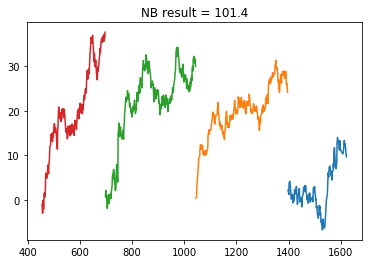

In [38]:
plot_res(full_res_naive,'NB result ='+' '+str(round(full_res_naive.profit.sum(),1)))

In [39]:
print('test year profit =',full_res_naive.loc[full_res_naive.season==19].profit.sum())

test year profit = 9.63


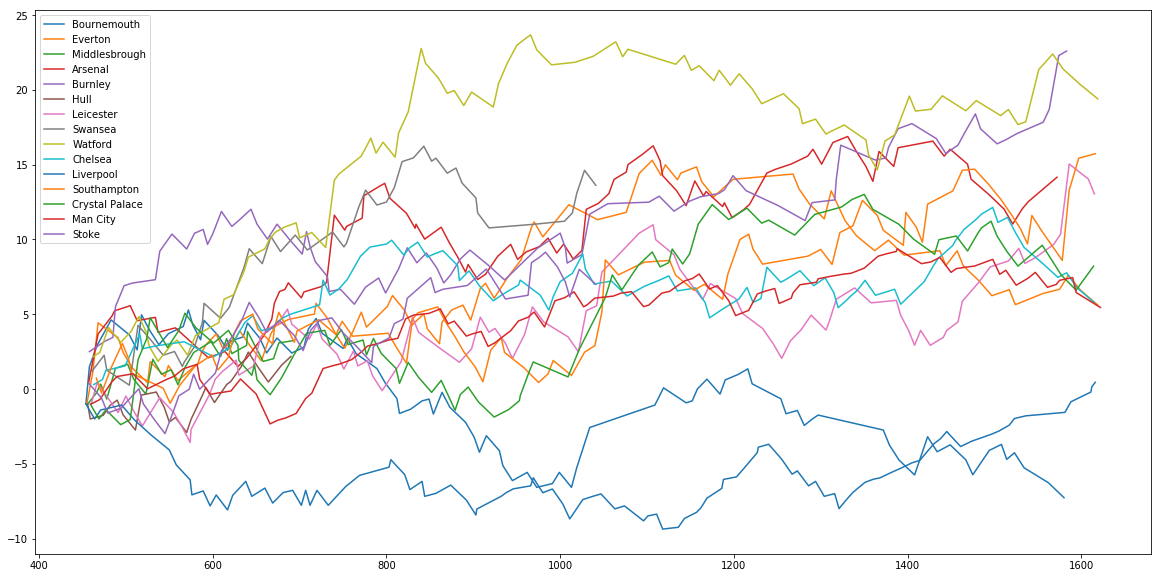

In [41]:
plt.figure(figsize=(20,10))
teams = list(full_res_naive.home_team_name.unique())

for team in teams[:15]:
    
    plt.plot(full_res_naive.loc[(full_res_naive.home_team_name==team)|(full_res_naive.away_team_name==team)].\
             profit.cumsum(),label=team)

plt.legend(loc="upper left")
plt.show()